In [ ]:
import cv2

Imagen encontrada: /content/0014_0017.jpg


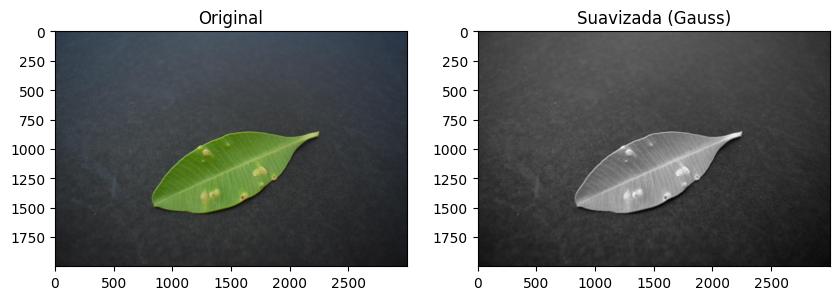

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
from scipy.signal import convolve2d

# --- 1. DEFINICIÓN DE FUNCIONES ---
def crear_kernel_gaussiano(tamano, sigma):
    kernel_1d = np.linspace(-(tamano // 2), tamano // 2, tamano)
    for i in range(tamano):
        kernel_1d[i] = np.exp(-0.5 * (kernel_1d[i] / sigma)**2)
    kernel_2d = np.outer(kernel_1d.T, kernel_1d)
    kernel_2d *= 1.0 / kernel_2d.max()
    return kernel_2d / kernel_2d.sum()

def aplicar_convolucion(imagen, kernel):
    return convolve2d(imagen, kernel, mode='same', boundary='symm')

def rgb2gray_manual(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

# --- 2. CARGA Y PREPROCESAMIENTO ---
# NOTA: Asegúrate de subir una foto y poner su nombre EXACTO aquí abajo ↓
ruta = "/content/0014_0017.jpg"

if os.path.exists(ruta):
    print(f"Imagen encontrada: {ruta}")

    # Cargar y Normalizar
    img_original = mpimg.imread(ruta)
    if img_original.max() <= 1.0:
        img_original = (img_original * 255).astype(np.uint8)

    # A. Redimensionado (Subsampling)
    img_resized = img_original[::2, ::2]

    # B. Escala de Grises Manual
    img_gris = rgb2gray_manual(img_resized)

    # C. Filtro Gaussiano Manual
    kernel_gauss = crear_kernel_gaussiano(tamano=5, sigma=1.0)
    img_suavizada = aplicar_convolucion(img_gris, kernel_gauss)

    # D. Visualización de control (Para saber que funcionó)
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1); plt.imshow(img_resized); plt.title("Original")
    plt.subplot(1,2,2); plt.imshow(img_suavizada, cmap='gray'); plt.title("Suavizada (Gauss)")
    plt.show()

else:
    # ESTE ES EL AVISO QUE TE FALTABA
    print(f"ERROR: No se encontró el archivo: {ruta}")

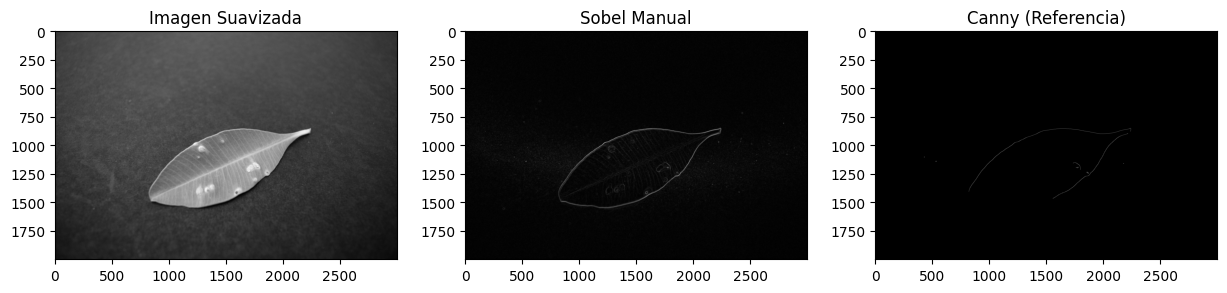

In [ ]:
# --- 3. COMPARATIVA DE BORDES (SOBEL vs CANNY) ---

if 'img_suavizada' in locals(): # Solo corre si la imagen cargó antes
    # 1. Sobel Manual
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.array([[-1, -2, -1], [ 0,  0,  0], [ 1,  2,  1]])

    Ix = aplicar_convolucion(img_suavizada, Kx)
    Iy = aplicar_convolucion(img_suavizada, Ky)

    sobel_manual = np.hypot(Ix, Iy)
    sobel_manual = (sobel_manual / sobel_manual.max() * 255).astype(np.uint8)

    # 2. Canny (Referencia)
    canny_ref = cv2.Canny(img_suavizada.astype(np.uint8), 50, 150)

    # Visualización
    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1); plt.imshow(img_suavizada, cmap='gray'); plt.title("Imagen Suavizada")
    plt.subplot(1,3,2); plt.imshow(sobel_manual, cmap='gray'); plt.title("Sobel Manual")
    plt.subplot(1,3,3); plt.imshow(canny_ref, cmap='gray'); plt.title("Canny (Referencia)")
    plt.show()

Máscara ROI regenerada usando Binarización Otsu.


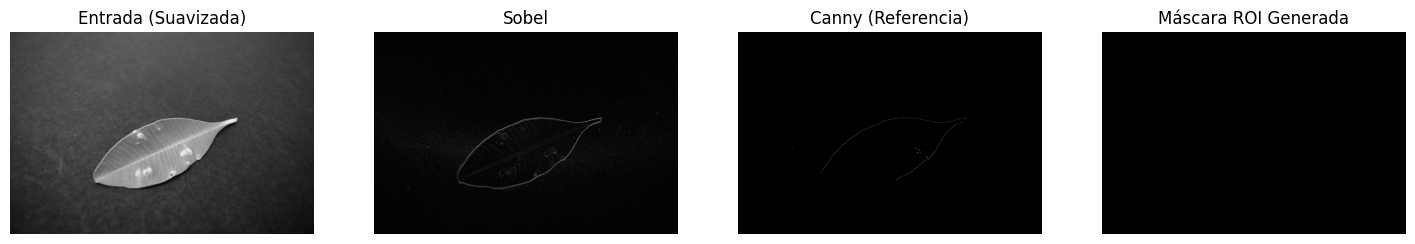

In [ ]:
# DEFINICIÓN DE KERNELS SOBEL
Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
Ky = np.array([[-1, -2, -1], [ 0,  0,  0], [ 1,  2,  1]])

Ix = aplicar_convolucion(img_suavizada, Kx)
Iy = aplicar_convolucion(img_suavizada, Ky)

sobel_manual = np.hypot(Ix, Iy)
sobel_manual = sobel_manual / sobel_manual.max() * 255
sobel_manual = sobel_manual.astype(np.uint8)

# ALGORITMO CANNY (REFERENCIA VISUAL)
img_suavizada_uint8 = img_suavizada.astype(np.uint8)
canny_ref = cv2.Canny(img_suavizada_uint8, 50, 150)

# CREACIÓN DE MÁSCARA ROI (CORREGIDO CON BINARIZACIÓN)
# EN LUGAR DE CANNY, USAMOS UMBRALIZACIÓN (THRESHOLDING)
# Esto crea una forma sólida, ignorando la textura interna de la hoja.

# 1. Aplicamos umbralización de Otsu invertida (Hoja oscura = Blanco, Fondo claro = Negro)
# Otsu calcula automáticamente el valor de corte.
ret, thresh = cv2.threshold(img_suavizada_uint8, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 2. Encontrar contornos sobre la mancha sólida
contornos, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 3. Crear imagen negra vacía
mascara_roi = np.zeros_like(img_suavizada, dtype=np.uint8)

# 4. Rellenar el contorno más grande (la hoja completa)
if contornos:
    c_max = max(contornos, key=cv2.contourArea)
    cv2.drawContours(mascara_roi, [c_max], -1, (255), thickness=cv2.FILLED)

print("Máscara ROI regenerada usando Binarización Otsu.")

# VISUALIZACIÓN COMPARATIVA
plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.imshow(img_suavizada, cmap='gray')
plt.title("Entrada (Suavizada)")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(sobel_manual, cmap='gray')
plt.title("Sobel")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(canny_ref, cmap='gray')
plt.title("Canny (Referencia)")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(mascara_roi, cmap='gray')
plt.title("Máscara ROI Generada")
plt.axis('off')

plt.show()

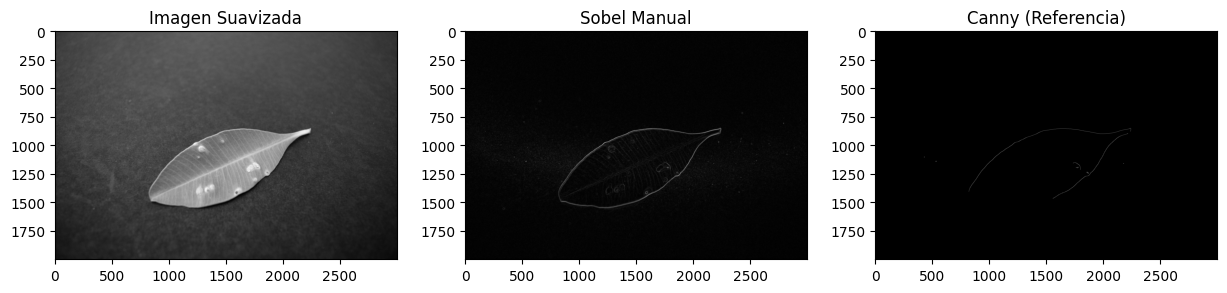

In [ ]:
# COMPARATIVA DE BORDES (SOBEL MANUAL vs CANNY)
# Requisito: Comparar detección manual vs librería

# 1. Definición Manual de Kernels Sobel
Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
Ky = np.array([[-1, -2, -1], [ 0,  0,  0], [ 1,  2,  1]])

# 2. Aplicar Convolución (Usando tu función 'aplicar_convolucion' definida arriba)
# Nota: Asegúrate de que 'img_suavizada' existe en tu celda anterior
Ix = aplicar_convolucion(img_suavizada, Kx)
Iy = aplicar_convolucion(img_suavizada, Ky)

# 3. Calcular Magnitud del Gradiente (Hipotenusa)
sobel_manual = np.hypot(Ix, Iy)
sobel_manual = (sobel_manual / sobel_manual.max() * 255).astype(np.uint8)

# 4. Canny (Referencia de OpenCV para comparar)
canny_ref = cv2.Canny(img_suavizada.astype(np.uint8), 50, 150)

# Visualización
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1); plt.imshow(img_suavizada, cmap='gray'); plt.title("Imagen Suavizada")
plt.subplot(1,3,2); plt.imshow(sobel_manual, cmap='gray'); plt.title("Sobel Manual")
plt.subplot(1,3,3); plt.imshow(canny_ref, cmap='gray'); plt.title("Canny (Referencia)")
plt.show()

ROI generada con éxito (Sombras eliminadas).


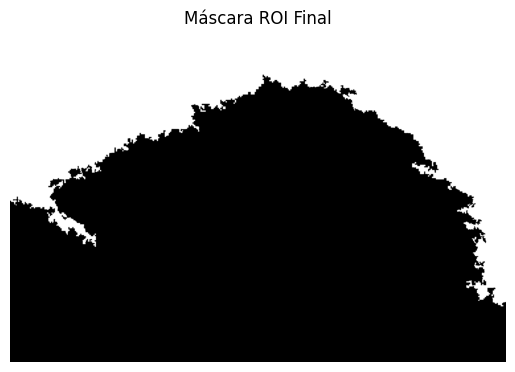

In [ ]:
#SEGMENTACIÓN ROI (SOLUCIÓN ANTI-SOMBRA)
# Usamos el canal de Saturación (HSV) para ignorar sombras grises/negras

# 1. Convertir a HSV
# Asegúrate de usar 'img_resized' que definiste en tu primera celda
hsv_roi = cv2.cvtColor(img_resized, cv2.COLOR_RGB2HSV)
S_channel = hsv_roi[:, :, 1] # Canal Saturación

# 2. Umbralización Manual (NumPy)
# Regla: Si Saturación > 40, es hoja. Si es menor, es sombra/fondo.
mask_sin_sombra = (S_channel > 40).astype(np.uint8) * 255

# 3. Limpieza de Ruido
kernel_clean = np.ones((5,5), np.uint8)
mask_sin_sombra = cv2.morphologyEx(mask_sin_sombra, cv2.MORPH_OPEN, kernel_clean)
mask_sin_sombra = cv2.morphologyEx(mask_sin_sombra, cv2.MORPH_CLOSE, kernel_clean)

# 4. Quedarnos solo con la hoja (Contorno más grande)
contornos, _ = cv2.findContours(mask_sin_sombra, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mascara_roi = np.zeros_like(S_channel, dtype=np.uint8)

if contornos:
    c_max = max(contornos, key=cv2.contourArea)
    cv2.drawContours(mascara_roi, [c_max], -1, (255), thickness=cv2.FILLED)

print("ROI generada con éxito (Sombras eliminadas).")
plt.imshow(mascara_roi, cmap='gray'); plt.title("Máscara ROI Final"); plt.axis('off'); plt.show()

In [ ]:
# CLASIFICACIÓN DE TEJIDO

# 1. Preparar imagen enmascarada (Manual con NumPy)
# Apilamos la máscara 3 veces para que tenga canales RGB
mascara_3c = np.dstack((mascara_roi, mascara_roi, mascara_roi))
# Multiplicamos: Imagen * 1 = Imagen, Imagen * 0 = Negro
img_con_mascara = img_resized * (mascara_3c // 255)

# 2. Análisis de Color HSV
img_hsv = cv2.cvtColor(img_con_mascara, cv2.COLOR_RGB2HSV)
H = img_hsv[:, :, 0]
S = img_hsv[:, :, 1]
V = img_hsv[:, :, 2]

# 3. Definir Rangos (Lógica Manual NumPy)
# Sano: Tonalidades Verdes (Hue 35 a 90)
mask_sano = (H > 35) & (H < 90) & (S > 30) & (V > 30)

# Enfermo: Tonalidades Rojas/Marrones/Amarillas (Hue 0-35 y 160-180)
mask_enfermo = ((H >= 0) & (H <= 35) | (H >= 160) & (H <= 180)) & (S > 30) & (V > 30)

# 4. Restricción ROI y Limpieza
# Aseguramos que solo cuente lo que está DENTRO de la hoja
mask_sano = mask_sano & (mascara_roi > 0)
mask_enfermo = mask_enfermo & (mascara_roi > 0)

# Convertir a 0-255 y limpiar puntitos sueltos
kernel_morph = np.ones((3,3), np.uint8)
mask_enfermo_vis = cv2.morphologyEx(mask_enfermo.astype(np.uint8)*255, cv2.MORPH_CLOSE, kernel_morph)
mask_sano_vis = cv2.morphologyEx(mask_sano.astype(np.uint8)*255, cv2.MORPH_CLOSE, kernel_morph)

print("Clasificación de tejido completada.")

Clasificación de tejido completada.


Máscara ROI generada (Saturación).


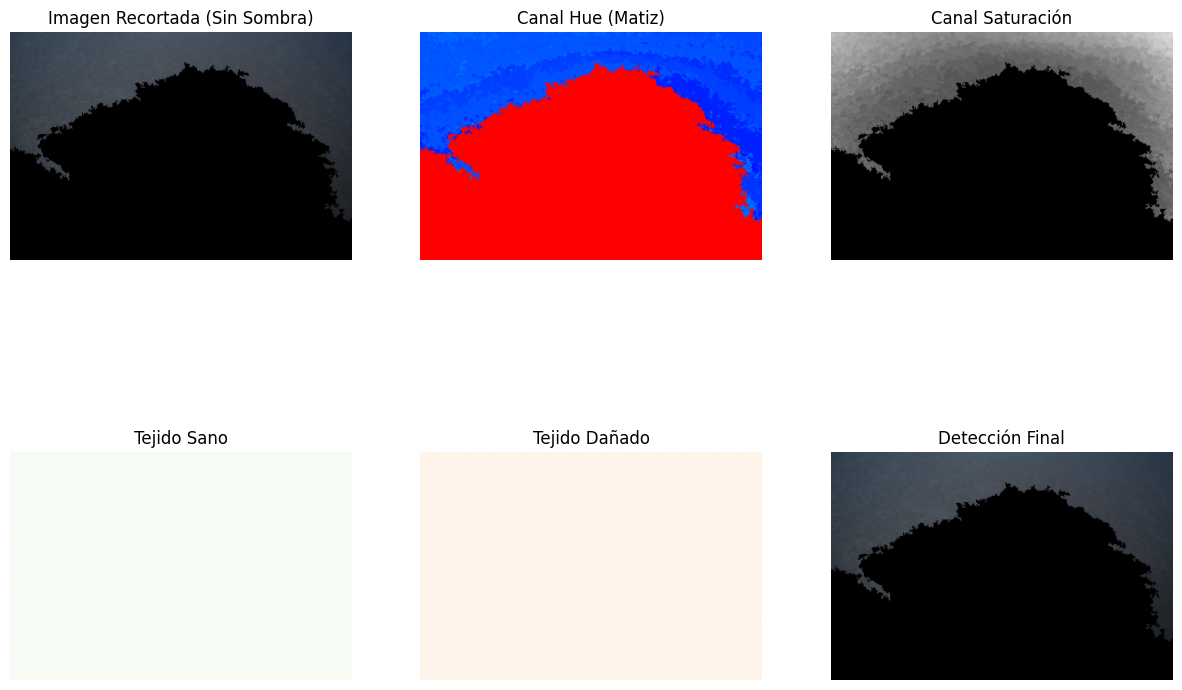

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# CREACIÓN DE MÁSCARA ROI
# Usamos la saturación para ignorar sombras grises/negras.

# Convertimos a HSV
hsv_roi = cv2.cvtColor(img_resized, cv2.COLOR_RGB2HSV)
S_channel = hsv_roi[:, :, 1]

# Umbral de saturación > 40 (Ignora sombras)
mask_sin_sombra = (S_channel > 40).astype(np.uint8) * 255

# Limpieza morfológica
kernel_clean = np.ones((5,5), np.uint8)
mask_sin_sombra = cv2.morphologyEx(mask_sin_sombra, cv2.MORPH_OPEN, kernel_clean)
mask_sin_sombra = cv2.morphologyEx(mask_sin_sombra, cv2.MORPH_CLOSE, kernel_clean)

# Seleccionar solo la hoja (contorno más grande)
contornos, _ = cv2.findContours(mask_sin_sombra, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mascara_roi = np.zeros_like(S_channel, dtype=np.uint8)

if contornos:
    c_max = max(contornos, key=cv2.contourArea)
    cv2.drawContours(mascara_roi, [c_max], -1, (255), thickness=cv2.FILLED)

print("Máscara ROI generada (Saturación).")


#SEGMENTACIÓN DE ENFERMEDAD
# Ahora usamos la nueva 'mascara_roi' para buscar la enfermedad

# 1. Aplicar la máscara a la imagen original
mascara_roi_3c = cv2.merge([mascara_roi, mascara_roi, mascara_roi])
img_con_mascara = np.bitwise_and(img_resized, mascara_roi_3c)

# 2. Análisis de Color (HSV)
img_hsv = cv2.cvtColor(img_con_mascara, cv2.COLOR_RGB2HSV)
H = img_hsv[:, :, 0]
S = img_hsv[:, :, 1]
V = img_hsv[:, :, 2]

# 3. Definir rangos
# Sano: Verde
mask_sano = (H > 35) & (H < 90) & (S > 30) & (V > 30)

# Enfermo: Amarillo, Marrón, Naranja (Todo lo que no es verde pero tiene color)
# Rango 1: Rojos/Naranjas/Marrones (0 a 35)
# Rango 2: Rojos oscuros al final del espectro (160 a 180)
mask_enfermo = ((H >= 0) & (H <= 35) | (H >= 160) & (H <= 180)) & (S > 30) & (V > 30)

# Limpiar usando la ROI
mask_sano = mask_sano & (mascara_roi > 0)
mask_enfermo = mask_enfermo & (mascara_roi > 0)

# Convertir a formato visual (0-255)
mask_sano_vis = (mask_sano.astype(np.uint8)) * 255
mask_enfermo_vis = (mask_enfermo.astype(np.uint8)) * 255

# Limpieza final de manchas
kernel_morph = np.ones((3,3), np.uint8)
mask_enfermo_limpia = cv2.morphologyEx(mask_enfermo_vis, cv2.MORPH_CLOSE, kernel_morph)
mask_sano_limpia = cv2.morphologyEx(mask_sano_vis, cv2.MORPH_CLOSE, kernel_morph)


# VISUALIZACIÓN
plt.figure(figsize=(15, 10))

# Fila 1
plt.subplot(2, 3, 1)
plt.imshow(img_con_mascara)
plt.title("Imagen Recortada (Sin Sombra)")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(H, cmap='hsv')
plt.title("Canal Hue (Matiz)")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(S, cmap='gray')
plt.title("Canal Saturación")
plt.axis('off')

# Fila 2
plt.subplot(2, 3, 4)
plt.imshow(mask_sano_limpia, cmap='Greens')
plt.title("Tejido Sano")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(mask_enfermo_limpia, cmap='Oranges')
plt.title("Tejido Dañado")
plt.axis('off')

# Resultado Superpuesto
resultado_visual = img_con_mascara.copy()
resultado_visual[mask_enfermo_limpia == 255] = [255, 0, 0] # Pintar rojo

plt.subplot(2, 3, 6)
plt.imshow(resultado_visual)
plt.title("Detección Final")
plt.axis('off')

plt.show()

REPORTE DE SALUD VEGETAL
Píxeles de Tejido Sano:    0
Píxeles de Tejido Dañado:  3
Área Total (en píxeles):   3
------------------------------
SALUD GLOBAL: 0.00%
DAÑO DETECTADO: 100.00%


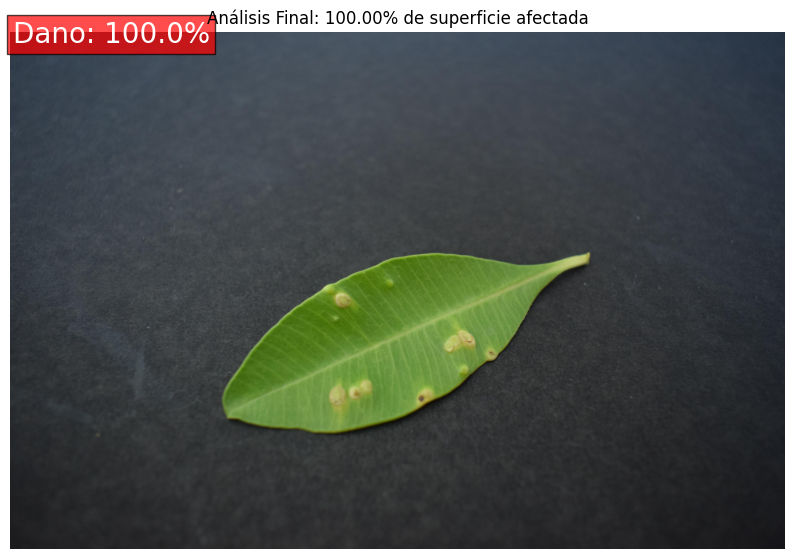

In [ ]:
# 1. CONTEO DE PÍXELES
# Contamos los píxeles que no sean cero en las máscaras limpias
pixeles_sanos = np.count_nonzero(mask_sano_limpia)
pixeles_enfermos = np.count_nonzero(mask_enfermo_limpia)

# 2. CÁLCULOS
# Área total de la hoja
area_total_hoja = pixeles_sanos + pixeles_enfermos

# Evitamos división por cero por si acaso la máscara salió vacía
if area_total_hoja > 0:
    porcentaje_dano = (pixeles_enfermos / area_total_hoja) * 100
    porcentaje_sano = (pixeles_sanos / area_total_hoja) * 100
else:
    porcentaje_dano = 0
    porcentaje_sano = 0

# 3. IMPRESIÓN DE DATOS
print("REPORTE DE SALUD VEGETAL")
print(f"Píxeles de Tejido Sano:    {pixeles_sanos}")
print(f"Píxeles de Tejido Dañado:  {pixeles_enfermos}")
print(f"Área Total (en píxeles):   {area_total_hoja}")
print("-" * 30)
print(f"SALUD GLOBAL: {porcentaje_sano:.2f}%")
print(f"DAÑO DETECTADO: {porcentaje_dano:.2f}%")


# 4. GENERACIÓN DE LA IMAGEN FINAL
plt.figure(figsize=(10, 8))

# Mostramos la imagen original
plt.imshow(img_resized)

# Superponemos la máscara de daño en color ROJO con transparencia (alpha)
# Creamos una imagen roja sólida
capa_roja = np.zeros_like(img_resized)
capa_roja[:] = [255, 0, 0] # Rojo puro

# Usamos la máscara de enfermedad para decir dónde pintar
# Convertimos la máscara a booleano para usarla como índice
mask_bool = mask_enfermo_limpia > 0

# Pintamos solo donde hay enfermedad usando transparencia manual
# Fórmula: Imagen_Final = Imagen_Original * (1 - alpha) + Capa_Roja * alpha
alpha = 0.5 # Transparencia del 50%
img_final_vis = img_resized.copy()

# Solo modificamos los píxeles donde la máscara es True
img_final_vis[mask_bool] = (
    img_final_vis[mask_bool] * (1 - alpha) +
    capa_roja[mask_bool] * alpha
).astype(np.uint8)

plt.imshow(img_final_vis)

# Añadimos el texto del porcentaje sobre la imagen
texto_resultado = f"Dano: {porcentaje_dano:.1f}%"
plt.text(10, 40, texto_resultado, fontsize=20, color='white',
         bbox=dict(facecolor='red', alpha=0.7))

plt.title(f"Análisis Final: {porcentaje_dano:.2f}% de superficie afectada")
plt.axis('off')

plt.show()


=== REPORTE DE SALUD VEGETAL ===
Píxeles Dañados: 3
Área Hoja:       2092284
DAÑO DETECTADO:  0.00%


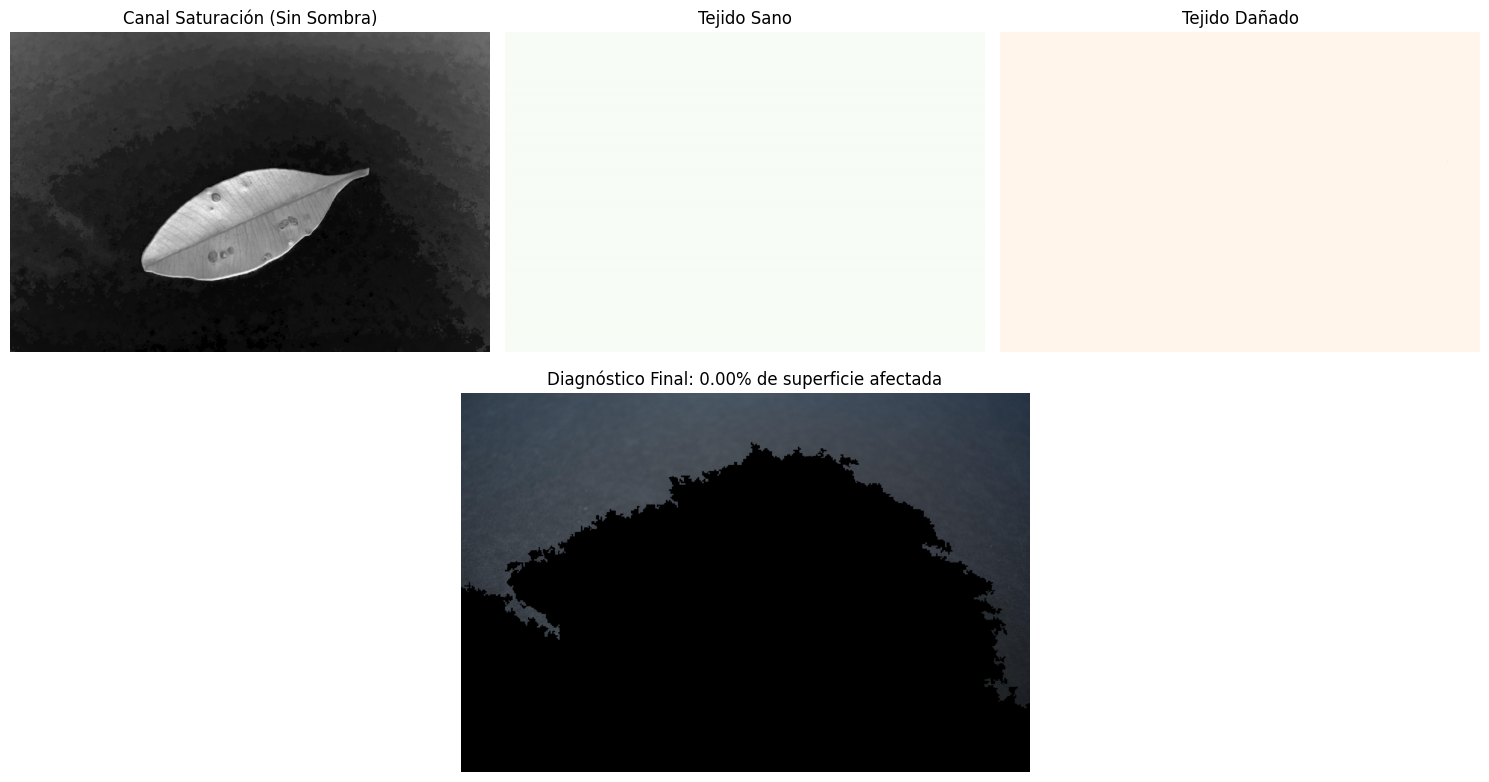

In [ ]:
# --- CÁLCULO DE DAÑO Y VISUALIZACIÓN FINAL ---

# 1. Conteo de Píxeles
pixeles_enfermos = np.count_nonzero(mask_enfermo_vis)
area_total = np.count_nonzero(mascara_roi) # Área real de la hoja (sin fondo)

# 2. Cálculo de Porcentaje
if area_total > 0:
    dano_pct = (pixeles_enfermos / area_total) * 100
else:
    dano_pct = 0

print(f"\n=== REPORTE DE SALUD VEGETAL ===")
print(f"Píxeles Dañados: {pixeles_enfermos}")
print(f"Área Hoja:       {area_total}")
print(f"DAÑO DETECTADO:  {dano_pct:.2f}%")

# 3. Generar Gráfica Final
plt.figure(figsize=(15, 8))

# A. Canal Saturación (Prueba técnica de eliminación de sombra)
plt.subplot(2, 3, 1); plt.imshow(S_channel, cmap='gray'); plt.title("Canal Saturación (Sin Sombra)")
plt.axis('off')

# B. Clasificación
plt.subplot(2, 3, 2); plt.imshow(mask_sano_vis, cmap='Greens'); plt.title("Tejido Sano")
plt.axis('off')
plt.subplot(2, 3, 3); plt.imshow(mask_enfermo_vis, cmap='Oranges'); plt.title("Tejido Dañado")
plt.axis('off')

# C. Resultado Superpuesto
res_visual = img_con_mascara.copy()
# Pintar de rojo puro (255, 0, 0) donde la máscara de enfermedad es blanca
res_visual[mask_enfermo_vis == 255] = [255, 0, 0]

plt.subplot(2, 1, 2); plt.imshow(res_visual);
plt.title(f"Diagnóstico Final: {dano_pct:.2f}% de superficie afectada"); plt.axis('off')

plt.tight_layout()
plt.show()